In [1]:
import numpy as np, random, operator, pandas as pd, matplotlib.pyplot as plt

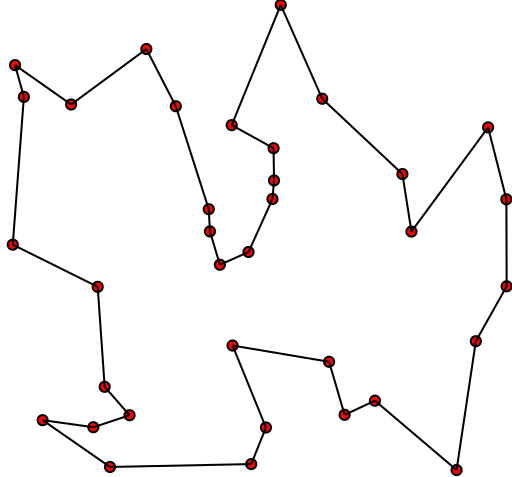

In [2]:
from IPython.display import Image
Image(filename='1.png')

<font size=5>每座城市仅访问一次（不重不漏）
必须返回起始城市</font>

<font size=3>
    
gene: 一座城市（以(x, y)坐标表示）
    
individual: 或染色体（chromosome）： 满足以上条件的一个路由
    
population: 一组可能的路由（即，一组个体）
    
parents: 两个路由相组合，创建一个新路由
    
mating pool: 一组父母，用来创建下一代种群（即创建下一代路由）
    
fitness: 一个告诉我们每个路由有多好的函数（在我们的例子中，也就是距离多短）
    
mutation: 在种群中引入变化的方法，随机交换路由中的两个城市
    
Elitism: 将最好的个体保留至下一代
</font>

## Create necessary classes and functions

Create class to handle "cities"

In [3]:
class City:
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def distance(self, city):
        xDis = abs(self.x - city.x)
        yDis = abs(self.y - city.y)
        distance = np.sqrt((xDis ** 2) + (yDis ** 2))
        return distance
    
    def __repr__(self):
        return "(" + str(self.x) + "," + str(self.y) + ")"

Create a fitness function

In [4]:
class Fitness:
    def __init__(self, route):
        self.route = route
        self.distance = 0
        self.fitness= 0.0
    
    def routeDistance(self):
        if self.distance ==0:
            pathDistance = 0
            for i in range(0, len(self.route)):
                fromCity = self.route[i]
                toCity = None
                if i + 1 < len(self.route):
                    toCity = self.route[i + 1]
                else:
                    toCity = self.route[0]
                pathDistance += fromCity.distance(toCity)
            self.distance = pathDistance
        return self.distance
    
    def routeFitness(self):
        if self.fitness == 0:
            self.fitness = 1 / float(self.routeDistance())
        return self.fitness

## Create our initial population

Route generator

In [5]:
def createRoute(cityList):
    route = random.sample(cityList, len(cityList))
    return route

Create first "population" (list of routes)

In [6]:
def initialPopulation(popSize, cityList):
    population = []

    for i in range(0, popSize):
        population.append(createRoute(cityList))
    return population

## Create the genetic algorithm

Rank individuals

In [7]:
def rankRoutes(population):
    fitnessResults = {}
    for i in range(0,len(population)):
        fitnessResults[i] = Fitness(population[i]).routeFitness()
    return sorted(fitnessResults.items(), key = operator.itemgetter(1), reverse = True)

Create a selection function that will be used to make the list of parent routes

<font size=3>我们为每个个体计算相对适应度权重（创建轮盘），然后将这些权重与一个随机数比较，以选择交配池。同时，我们打算保留最佳的路由，因此引入了精英选择。最后，selection函数返回路由ID的列表，供matingPool函数使用。</font>

In [8]:
def selection(popRanked, eliteSize):
    selectionResults = []
    df = pd.DataFrame(np.array(popRanked), columns=["Index","Fitness"])
    df['cum_sum'] = df.Fitness.cumsum()
    df['cum_perc'] = 100*df.cum_sum/df.Fitness.sum()
    
    for i in range(0, eliteSize):
        selectionResults.append(popRanked[i][0])
    for i in range(0, len(popRanked) - eliteSize):
        pick = 100*random.random()
        for i in range(0, len(popRanked)):
            if pick <= df.iat[i,3]:
                selectionResults.append(popRanked[i][0])
                break
    return selectionResults

Create mating pool

In [9]:
def matingPool(population, selectionResults):
    matingpool = []
    for i in range(0, len(selectionResults)):
        index = selectionResults[i]
        matingpool.append(population[index])
    return matingpool

Create a crossover function for two parents to create one child

<font size=3>TSP要求每个位置出现且仅出现一次。为了遵循这条规则，我们将使用一种特殊的繁殖函数有序交叉（ordered crossover）。在有序交叉中，我们随机选择父字符串的一个子集，然后用母字符串中的基因填充路由的剩余空位。填充时，按照基因在母字符串中出现的次序依次填充，跳过选中的父字符串子集中已有的基因。</font>

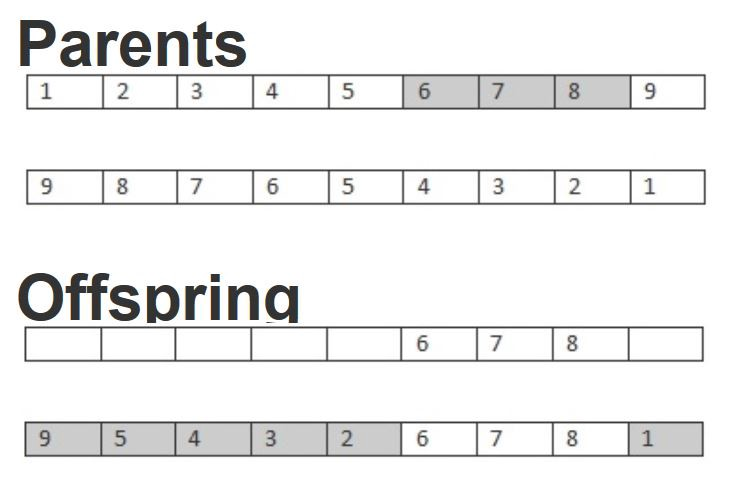

In [10]:
Image(filename='2.jpeg')

In [11]:
def breed(parent1, parent2):
    child = []
    childP1 = []
    childP2 = []
    
    geneA = int(random.random() * len(parent1))
    geneB = int(random.random() * len(parent1))
    
    startGene = min(geneA, geneB)
    endGene = max(geneA, geneB)

    for i in range(startGene, endGene):
        childP1.append(parent1[i])
        
    childP2 = [item for item in parent2 if item not in childP1]

    child = childP1 + childP2
    return child

Create function to run crossover over full mating pool

In [12]:
def breedPopulation(matingpool, eliteSize):
    children = []
    length = len(matingpool) - eliteSize
    pool = random.sample(matingpool, len(matingpool))

    for i in range(0,eliteSize):
        children.append(matingpool[i])
    
    for i in range(0, length):
        child = breed(pool[i], pool[len(matingpool)-i-1])
        children.append(child)
    return children

Create function to mutate a single route

<font size=3>变异在GA中起到了重要作用，它通过引入新路由让我们得以探索解答空间的其他部分，避免收敛到局部最优值。和交叉类似，TSP问题中的变异需要特殊考虑。同样，如果我们的染色体由0和1组成，变异不过是给基因分配一个较低的由0变为1（或由1变0）的概率。

然而，因为我们需要遵守TSP的规则，我们无法丢弃城市。我们将转而使用交换变异（swap mutation）。这意味着，我们指定一个较低的概率，两座城市会在我们的路由中交换位置。</font>

In [13]:
def mutate(individual, mutationRate):
    for swapped in range(len(individual)):
        if(random.random() < mutationRate):
            swapWith = int(random.random() * len(individual))
            
            city1 = individual[swapped]
            city2 = individual[swapWith]
            
            individual[swapped] = city2
            individual[swapWith] = city1
    return individual

Create function to run mutation over entire population

In [14]:
def mutatePopulation(population, mutationRate):
    mutatedPop = []
    
    for ind in range(0, len(population)):
        mutatedInd = mutate(population[ind], mutationRate)
        mutatedPop.append(mutatedInd)
    return mutatedPop

Put all steps together to create the next generation

In [15]:
def nextGeneration(currentGen, eliteSize, mutationRate):
    popRanked = rankRoutes(currentGen)
    selectionResults = selection(popRanked, eliteSize)
    matingpool = matingPool(currentGen, selectionResults)
    children = breedPopulation(matingpool, eliteSize)
    nextGeneration = mutatePopulation(children, mutationRate)
    return nextGeneration

Final step: create the genetic algorithm

In [16]:
# index=[]
convergence=[]
def geneticAlgorithm(population, popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, population)
    print("Initial distance: " + str(1 / rankRoutes(pop)[0][1]))
    
    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate)
        # index.append(1)
        length_i=1/rankRoutes(pop)[0][1]
        convergence.append(length_i)
        print(i,length_i)
    
    print("Final distance: " + str(1 / rankRoutes(pop)[0][1]))
    bestRouteIndex = rankRoutes(pop)[0][0]
    bestRoute = pop[bestRouteIndex]
    return bestRoute

# # check the convergence
# convergence
# size=len(convergence)
# pairs=[list(range(1,size+1)),convergence]
# pairs


## Running the genetic algorithm

Create list of cities

In [17]:
# # test data1(randon data)

# cityList = []

# for i in range(0,25):
#     cityList.append(City(x=int(random.random() * 200), y=int(random.random() * 200)))
# # cityList.append(123,444)
# cityList

In [18]:
# test data2:location from TSP_data.csv file

cityList=pd.read_csv("./TSP_data.csv",names=["location","latitude","longtitude"])
cityList=cityList[["latitude","longtitude"]]
cityList=cityList.values.tolist()
# cityList=[tuple(list_item) for list_item in cityList]
cityList=[City(list_item[0],list_item[1]) for list_item in cityList]
# cityList.head(5)
cityList

[(116.46,39.92),
 (117.2,39.13),
 (121.48,31.22),
 (106.54,29.59),
 (91.11,29.97),
 (87.68,43.77),
 (106.27,38.47),
 (111.65,40.82),
 (108.33,22.84),
 (126.63,45.75),
 (125.35,43.88),
 (123.38,41.8),
 (114.48,38.03),
 (112.53,37.87),
 (101.74,36.56),
 (117.0,36.65),
 (113.6,34.76),
 (118.78,32.04),
 (117.27,31.86),
 (120.19,30.26),
 (119.3,26.08),
 (115.89,28.68),
 (113.0,28.21),
 (114.31,30.52),
 (113.23,23.16),
 (121.5,25.05),
 (110.35,20.02),
 (103.73,36.03),
 (108.95,34.27),
 (104.06,30.67),
 (106.71,26.57),
 (102.73,25.04),
 (114.1,22.2),
 (113.33,22.13)]

Run the genetic algorithm

In [19]:
##
geneticAlgorithm(population=cityList, popSize=100,
                 eliteSize=20, mutationRate=0.01, generations=300)

# check the convergence
convergence
size = len(convergence)
index = list(range(1, size+1))
# pairs=[index,convergence]
# pairs
plt.plot(index, convergence)

Initial distance: 411.62857026156496
0 411.62857026156496
1 398.75167292509474
2 392.29970860893616
3 381.0681366328377
4 374.9184502749958
5 371.6091343656402
6 343.6891196878449
7 353.662040494944
8 339.82446899534307
9 334.57406075565837
10 334.57406075565837
11 334.4236373811946
12 324.63626906719213
13 320.37304011358856
14 306.4019149033984
15 298.04803092509565
16 298.04803092509565
17 298.04803092509565
18 277.35949828367256
19 277.35949828367256
20 274.77285865435783
21 266.70645651691416
22 266.70645651691416
23 265.58275202780607
24 265.58275202780607
25 265.58275202780607
26 265.58275202780607
27 265.58275202780607
28 265.58275202780607
29 265.58275202780607
30 254.43731798534822
31 254.43731798534822
32 252.7019532798596
33 246.91281501647546
34 246.91281501647546
35 246.91281501647546
36 231.63297847455274
37 252.52929218141847
38 250.96698863694326
39 250.96698863694326
40 233.8951442382724
41 233.8951442382724
42 232.74184899101428
43 232.74184899101428
44 233.895144238